In [6]:
from crypto_indicators import CryptoTechnicalIndicators
import config
import pandas as pd


In [7]:
if __name__ == "__main__":
    # Instantiate the class with your database and collection names
    indicator_calculator = CryptoTechnicalIndicators(db_name=config.DATABASE_NAME, collection_name=config.COLLECTION_NAME)
    
    # Step 1: Load data from MongoDB
    indicator_calculator.load_data()
    
    # Step 2: Filter for symbol "ETH"
    indicator_calculator.data = indicator_calculator.data[indicator_calculator.data['symbol'] == 'ETH']
    if indicator_calculator.data.empty:
        print("No data found for symbol 'ETH'.")
    else:
        # Step 3: Calculate technical indicators if data is available
        indicator_calculator.calculate_indicators()
        
        # Step 4: Retrieve the DataFrame with indicators and print the first few rows
        indicator_df = indicator_calculator.get_indicator_df()
        indicator_df.dropna(inplace=True) 

Data loaded successfully from MongoDB.
Indicators calculated successfully.


In [8]:
# Assuming indicator_df and indicator_calculator.data are already defined

# Extract the 'close' column from indicator_calculator.data
close_column = indicator_calculator.data[['open','high', 'low','close']]

# Combine the close column with indicator_df
combined_df = pd.concat([close_column, indicator_df], axis=1)
# Drop rows with any NaN values
combined_df.dropna(inplace=True)
combined_df.head()
combined_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6887 entries, 2023-11-13 13:00:00 to 2024-11-08 20:00:00
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            6887 non-null   float64
 1   high            6887 non-null   float64
 2   low             6887 non-null   float64
 3   close           6887 non-null   float64
 4   RSI             6887 non-null   float64
 5   MACD            6887 non-null   float64
 6   CCI             6887 non-null   float64
 7   ADX             6887 non-null   float64
 8   ATR             6887 non-null   float64
 9   ROC             6887 non-null   float64
 10  Stdev           6887 non-null   float64
 11  Bollinger_High  6887 non-null   float64
 12  Bollinger_Low   6887 non-null   float64
 13  EMA             6887 non-null   float64
 14  Williams_%R     6887 non-null   float64
 15  Momentum        6887 non-null   float64
dtypes: float64(16)
memory usage: 914.7 KB


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize figure with subplots for candlestick and each indicator
fig = make_subplots(
    rows=4, cols=1,  # 4 rows: 1 for candlestick, 3 for indicators
    shared_xaxes=True,
    row_heights=[0.5, 0.15, 0.15, 0.15],
    vertical_spacing=0.02,
    subplot_titles=("OHLC with Bollinger Bands", "MACD", "RSI", "ADX")
)

# Add candlestick chart for OHLC data
fig.add_trace(
    go.Candlestick(
        x=combined_df.index,
        open=combined_df['open'],
        high=combined_df['high'],
        low=combined_df['low'],
        close=combined_df['close'],
        name="OHLC"
    ),
    row=1, col=1
)

# Add Bollinger Bands (High and Low) as line plots
fig.add_trace(
    go.Scatter(
        x=combined_df.index, 
        y=combined_df['Bollinger_High'], 
        mode='lines', 
        name='Bollinger High',
        line=dict(color='rgba(255, 0, 0, 0.5)')  # Semi-transparent red for upper band
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=combined_df.index, 
        y=combined_df['Bollinger_Low'], 
        mode='lines', 
        name='Bollinger Low',
        line=dict(color='rgba(0, 0, 255, 0.5)')  # Semi-transparent blue for lower band
    ),
    row=1, col=1
)

# Add MACD line plot
fig.add_trace(
    go.Scatter(
        x=combined_df.index, 
        y=combined_df['MACD'], 
        mode='lines', 
        name='MACD',
        line=dict(color='blue')
    ),
    row=2, col=1
)

# Add RSI line plot
fig.add_trace(
    go.Scatter(
        x=combined_df.index, 
        y=combined_df['RSI'], 
        mode='lines', 
        name='RSI',
        line=dict(color='purple')
    ),
    row=3, col=1
)

# Add CCI line plot
fig.add_trace(
    go.Scatter(
        x=combined_df.index, 
        y=combined_df['ADX'], 
        mode='lines', 
        name='ADX',
        line=dict(color='green')
    ),
    row=4, col=1
)

# Update layout for readability and interaction
fig.update_layout(
    title="Interactive OHLC Chart with Bollinger Bands, MACD, RSI, and ADX",
    xaxis_rangeslider_visible=False,  # Hide the default range slider under the candlestick chart
    hovermode="x unified",  # Show hover info for all subplots at once
    height=800  # Adjust height to fit subplots comfortably
)

# Show the interactive chart
fig.show()


In [10]:
import pandas as pd
from trading_env import TradingEnv
from q_learning_agent import QLearningAgent

# Initialize environment and Q-Learning agent
env = TradingEnv(combined_df)
state_space_size = len(combined_df.columns)  # Number of indicators in the state
agent = QLearningAgent(env.action_space.n, state_space_size)

# Training parameters
num_episodes = 100
for episode in range(num_episodes):
    obs = env.reset()
    state = agent.get_state(obs)
    total_reward = 0

    done = False
    while not done:
        # Choose an action based on the current state
        action = agent.choose_action(state)
        
        # Take action in the environment
        next_obs, reward, done, _ = env.step(action)
        total_reward += reward
        
        # Update the Q-value
        next_state = agent.get_state(next_obs)
        agent.update_q_value(state, action, reward, next_state)
        
        # Move to the next state
        state = next_state

    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

# Save trades for plotting
import pickle
with open("trades.pkl", "wb") as f:
    pickle.dump(env.trades, f)


Episode 1/100, Total Reward: -709
Episode 2/100, Total Reward: 24054
Episode 3/100, Total Reward: 28549
Episode 4/100, Total Reward: 28021
Episode 5/100, Total Reward: 28632
Episode 6/100, Total Reward: 28477
Episode 7/100, Total Reward: 28232
Episode 8/100, Total Reward: 28794
Episode 9/100, Total Reward: 26958
Episode 10/100, Total Reward: 27252
Episode 11/100, Total Reward: 26851
Episode 12/100, Total Reward: 26954
Episode 13/100, Total Reward: 26892
Episode 14/100, Total Reward: 27276
Episode 15/100, Total Reward: 26756
Episode 16/100, Total Reward: 27709
Episode 17/100, Total Reward: 27458
Episode 18/100, Total Reward: 27210
Episode 19/100, Total Reward: 27440
Episode 20/100, Total Reward: 27497
Episode 21/100, Total Reward: 27256
Episode 22/100, Total Reward: 28287
Episode 23/100, Total Reward: 26642
Episode 24/100, Total Reward: 27523
Episode 25/100, Total Reward: 27600
Episode 26/100, Total Reward: 28435
Episode 27/100, Total Reward: 28329
Episode 28/100, Total Reward: 27736
Ep

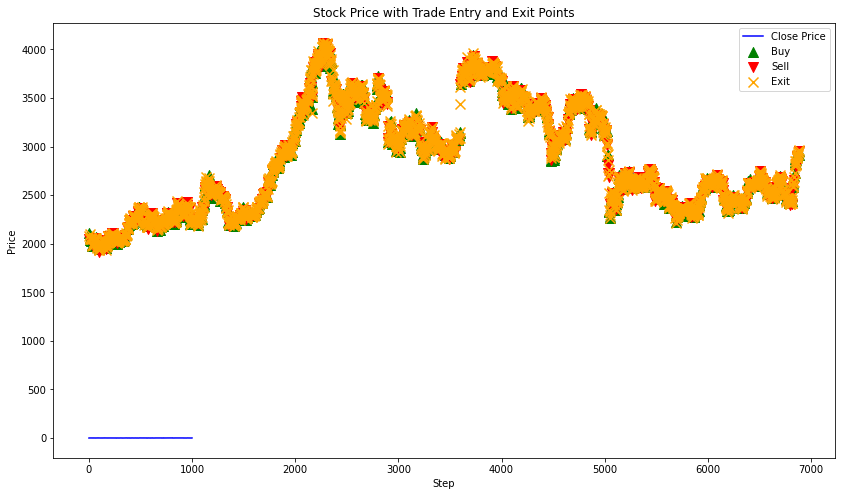

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load the data
combined_df = pd.DataFrame({
    'open': np.random.rand(1000),
    'high': np.random.rand(1000),
    'low': np.random.rand(1000),
    'close': np.random.rand(1000)
})

# Load trades from the file
with open("trades.pkl", "rb") as f:
    trades = pickle.load(f)

# Convert trades to a DataFrame for easy handling
trades_df = pd.DataFrame(trades, columns=['step', 'price', 'action'])

# Separate buy and sell actions for plotting
buy_trades = trades_df[trades_df['action'] == 'buy']
sell_trades = trades_df[trades_df['action'] == 'sell']
exit_trades = trades_df[trades_df['action'] == 'exit']

# Plot stock prices with buy/sell signals
plt.figure(figsize=(14, 8))
plt.plot(combined_df['close'], label='Close Price', color='blue')

# Plot buy, sell, and exit points
plt.scatter(buy_trades['step'], buy_trades['price'], color='green', marker='^', label='Buy', s=100)
plt.scatter(sell_trades['step'], sell_trades['price'], color='red', marker='v', label='Sell', s=100)
plt.scatter(exit_trades['step'], exit_trades['price'], color='orange', marker='x', label='Exit', s=100)

# Labeling and aesthetics
plt.title('Stock Price with Trade Entry and Exit Points')
plt.xlabel('Step')
plt.ylabel('Price')
plt.legend()
plt.show()
